<h1>Reiknum Kernel MNIST gagna</h1>

In [15]:
using MLDatasets, Flux, LinearAlgebra, ProgressMeter, Zygote
include("DenseNTK.jl"); include("FastNTK.jl")

function load_MNIST()
    """
    Loading the MNIST dataset.
    10 classes of digits from 0 to 9,
    each with 28x28 pixel dimensions.
    X: Grayscale vector, Y: Correct label.
    """

    X_training, Y_training = MNIST(split = :train)[:]
    X_testing, Y_testing = MNIST(split = :test)[:]
    X_training = Flux.flatten(X_training)
    X_testing = Flux.flatten(X_testing)
    Y_training = Flux.onehotbatch(Y_training, 0:9)
    Y_testing = Flux.onehotbatch(Y_testing, 0:9)
    return X_training, Y_training, X_testing, Y_testing
end

load_MNIST (generic function with 1 method)

In [2]:
# Model frá https://towardsdatascience.com/flux-jl-on-mnist-variations-of-a-theme-c3cd7a949f8c

model4LS = Chain(
  DenseNTK(28 * 28, 16, sigmoid),        # 784 x 16 + 16 = 12560 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  DenseNTK(16, 10, sigmoid)              #  16 x 10 + 10 =   170 parameters
)                                     #             --> 13274 parameters total

model3LS = Chain(
  DenseNTK(28 * 28, 60, sigmoid),        # 784 x 60 + 60 = 47100 parameters
  DenseNTK(60, 60, sigmoid),             #  60 x 60 + 60 =  3660 parameters
  DenseNTK(60, 10, sigmoid)              #  60 x 10 + 10 =   610 parameters
)                                     #             --> 51370 parameters total

model2LR = Chain(
  DenseNTK(28 * 28, 32, relu),           # 784 x 32 + 32 = 25120 parameters
  DenseNTK(32, 10),                      #  32 x 10 + 10 =   330 parameters
  softmax                             #             --> 25450 parameters total
)


display(Flux.params(model4LS))
Flux.destructure(model4LS)[2]

Params([Float32[0.8223987 -2.0087135 … -1.8210977 -0.74359214; -2.5655077 0.4672718 … -0.04328081 0.959693; … ; 0.80982625 -0.22557001 … -0.9759133 0.31414172; -1.5782744 -0.085643455 … -0.65916604 -0.77449477], Float32[-0.6889875, 0.46822712, -0.36207664, -0.18591155, 0.7721639, 0.09722289, 1.7344544, -0.6637633, 1.5773576, -0.45755342, -0.21370171, -0.7195869, 1.5627711, 0.491335, 0.641365, -1.6231617], Float32[-1.626966 1.7525356 … -0.16548148 2.3323681; 0.50216633 0.7826683 … -0.14098716 0.0944561; … ; -0.044570055 0.9888091 … -0.30976933 -0.7289519; -0.5048392 -0.47001714 … 0.61829656 0.01762338], Float32[1.8401024, -0.07251233, 1.1668675, -0.095536865, 0.16530499, 0.43574372, -0.30973983, 0.36226925, 0.6843971, -1.0599248, 2.6719725, 0.5538468, 0.97603554, -1.5704217, 0.698317, -1.7022948], Float32[-0.48964918 -0.31752285 … 0.25163442 1.6122587; -0.2880506 -0.17246057 … -1.4263065 -0.09646985; … ; -1.3460904 0.054917585 … 0.043522928 -2.0394127; 0.20603465 0.71330655 … 0.14413954

Restructure(Chain, ..., 13274)

In [3]:
N=10
x = load_MNIST()[1][:,1:N];

eig_fix(K) = abs.(eigen(K).values)

eig_fix (generic function with 1 method)

In [59]:
D = Flux.jacobian(() -> model4LS(x), Flux.params(model4LS))

all = vcat([p[:] for p in Flux.params(model4LS)]...)

all

13274-element Vector{Float32}:
 -1.5346988
 -1.725997
 -0.3948593
  0.960088
 -0.7814583
 -0.58625376
  1.5469338
  1.8175839
 -2.3178852
  0.26692703
  ⋮
 -0.89618033
  0.13467656
 -0.32667455
 -0.5888076
  1.1312925
  0.5923471
 -0.57472223
  0.8510967
  3.1920352

In [67]:
Zygote.refresh()
Zygote

In [5]:
K4LS = kernel(model4LS, x, true)
#K3LS = kernel(model3LS, x, true)
#K2LR = kernel(model2LR, x, true)

10×10 Matrix{Float64}:
  0.0865341     0.000114339  -0.000933409  …   0.000531581  -0.000560658
  0.000114339   0.0884187    -0.000769379      0.000375817  -0.000571968
 -0.000933409  -0.000769379   0.0702223        0.000267395   0.000193511
  0.000412945  -0.00205047    0.0010143        0.00100271   -1.50973e-5
  0.000551418  -0.000240371   0.000156209      0.00113364    0.000278402
 -0.00015004   -0.000851963  -0.000577463  …  -0.000785078   6.09694e-5
  0.000682755   0.00142689    0.000179026      0.00131135   -0.000620953
  0.000178631  -0.00128721   -0.000974905      0.000163637   0.000114363
  0.000531581   0.000375817   0.000267395      0.086983     -2.70643e-5
 -0.000560658  -0.000571968   0.000193511     -2.70643e-5    0.0068447

In [20]:
eig1 = eig_fix(K3LS)
eig2 = eig_fix(K2LR)
eig3 = eig_fix(K4LS)

1000-element Vector{Float64}:
 1.0416805314827912e-11
 1.546976310671029e-11
 2.5879748987295652e-11
 2.720787911986022e-11
 2.8306581203849105e-11
 3.1624277225259695e-11
 3.288156598610149e-11
 3.561933020147426e-11
 3.608714456034366e-11
 3.715502537660695e-11
 ⋮
 4.3574558744644385
 5.003761705409776
 5.197916547757945
 5.324264098824629
 5.906264702784812
 7.522112769673298
 7.829620356122388
 7.97797299077248
 8.42307842601754

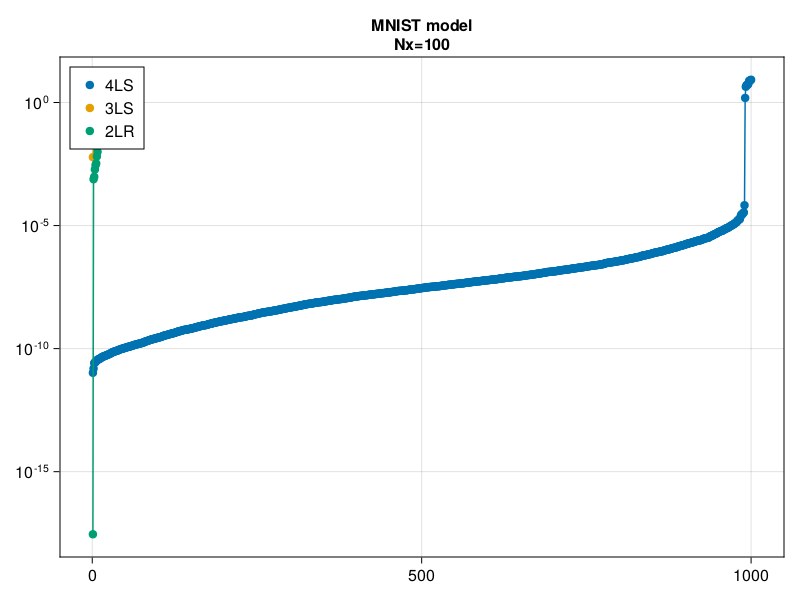

In [21]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1], yscale=log10, title="MNIST model\nNx=$N")

CairoMakie.scatter!(eig3, label="4LS")
CairoMakie.lines!(eig3)

CairoMakie.scatter!(eig1, label="3LS")
CairoMakie.lines!(eig1)

CairoMakie.scatter!(eig2, label="2LR")
CairoMakie.lines!(eig2)

axislegend(ax1,position=:lt)
fig

In [41]:
K = kernel(model4LS, x, true)

10×10 Matrix{Float64}:
  0.0740587    -0.000195749   0.00144944   …   0.00132828    0.000113314
 -0.000195749   0.0231077     0.000411827      0.00019968    0.000245803
  0.00144944    0.000411827   0.0752187        0.00113882    0.00056478
 -0.000693518   2.91948e-5    0.000257735     -0.000513839   0.000376113
  0.00106078    0.000328539   0.000455369      0.000784188   1.06808e-5
 -0.00061683   -0.000596974  -0.00188853   …   0.000389439  -0.0011355
  7.0968e-5     2.12263e-5   -7.06418e-5      -0.000376933  -0.000153647
 -0.00101157    0.00014602   -0.00022862       0.000791582   0.000774446
  0.00132828    0.00019968    0.00113882       0.0762006     0.000502347
  0.000113314   0.000245803   0.00056478       0.000502347   0.0123049

In [40]:
Kf = faster_kernel(model4LS,x,true)

10×10 Matrix{Float64}:
  0.0740587    -0.000195749   0.00144944   …   0.00132828    0.000113314
 -0.000195749   0.0231077     0.000411827      0.00019968    0.000245803
  0.00144944    0.000411827   0.0752187        0.00113882    0.00056478
 -0.000693518   2.91948e-5    0.000257735     -0.000513839   0.000376113
  0.00106078    0.000328539   0.000455369      0.000784188   1.06808e-5
 -0.00061683   -0.000596974  -0.00188853   …   0.000389439  -0.0011355
  7.0968e-5     2.12263e-5   -7.06418e-5      -0.000376933  -0.000153647
 -0.00101157    0.00014602   -0.00022862       0.000791582   0.000774446
  0.00132828    0.00019968    0.00113882       0.0762006     0.000502347
  0.000113314   0.000245803   0.00056478       0.000502347   0.0123049

In [89]:
Kff = fastest_kernel(model4LS,x,true)

Computing Kernel... 100%|██████████████████████████████████████████████████| Time: 0:00:12


1000×1000 Matrix{Float32}:
  0.0897211     0.000533088  -0.000814255  …   0.000515022   0.00207021
  0.000533088   0.00964604    0.000139832      0.000292611   0.000220287
 -0.000814255   0.000139832   0.0425676        0.0011503    -0.000331405
  0.00150207    0.000385426  -0.0004859        0.000175704   0.000459874
 -0.000253128   5.69241f-5    1.55443f-5       0.000400955   0.000677787
  0.00117998    8.14999f-5   -0.00158288   …   5.14529f-5   -0.000686154
 -0.00262436   -0.000152994   6.8012f-5       -0.000402358  -0.000216813
 -0.00130918   -0.000154888   0.000431345     -0.000684821   0.000315654
  0.000515984   0.000291923   0.00115174       0.0201261    -5.26458f-5
  0.00207437    0.000221016  -0.000333518     -5.25371f-5    0.0129895
  ⋮                                        ⋱                
  0.00053087    0.00963819    0.000140615      0.000293449   0.000219243
 -0.000810574   0.000140499   0.0424785        0.0011481    -0.000328448
  0.00150415    0.000384839  -0.00049106

In [21]:
Kult = ult_kernel(model4LS,x);

Time taken to calculate Jacobian: 0.04800009727478027
Time taken to contrsuct Kernel: 0.0019998550415039062


In [22]:
Ksplit = split_ult(model4LS,x,true);

In [29]:
round.(Kult, digits=15) == round.(Ksplit, digits=15)

false